# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt #for displaying plots
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import *
from keras.callbacks import *
from keras import regularizers
from keras.utils import plot_model

from tensorflow.keras.saving import register_keras_serializable

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
import datetime
import random
import properscoring as ps

from scipy.stats import norm
from scikeras.wrappers import KerasRegressor

import xgboost
import pydot
import graphviz

from keras.models import load_model
from sklearn.multioutput import MultiOutputRegressor
import pickle

from sklearn.model_selection import ParameterGrid
from pathlib import Path
import joblib
import shap
from sklearn.model_selection import cross_val_score


## Basic Setup

In [2]:
# setting a seed to ensure reproducability and consistency
random.seed(16)
np.random.seed(16)
tf.random.set_seed(16)

In [ ]:
plt.rcParams.update({'font.size': 13})

In [3]:
X_train = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_train_final.pkl")
X_valid = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_valid_final.pkl")
X_test = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\X_test_final.pkl")

y_train = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\y_train.pkl")
y_valid = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\y_valid.pkl")
y_test = pd.read_pickle(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Daten\y_test.pkl")


In [4]:
X_train.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,-0.039776,-0.397192,0,1,2,1.0,0.0,0.0,0.0,-0.218119,-0.031329,0
1,0.244625,-0.397192,0,1,3,1.0,0.0,0.0,0.0,-0.324284,-0.458165,0
2,0.381694,-0.371451,0,1,4,1.0,0.0,0.0,0.0,-1.076810,0.254435,0
3,1.300863,-0.397192,0,0,5,1.0,0.0,0.0,0.0,-0.405469,1.357699,0
4,0.745990,0.555250,0,0,6,1.0,0.0,0.0,0.0,0.297096,0.059103,0


In [5]:
X_valid.tail()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
359,-1.064496,-0.397192,0,1,1,0.0,0.0,0.0,1.0,-0.258711,-0.353265,1
360,-0.478837,-0.397192,0,1,2,0.0,0.0,0.0,1.0,1.087091,-0.823509,1
361,-0.104279,0.143383,0,1,3,0.0,0.0,0.0,1.0,2.276769,-0.913940,1
362,-0.691404,0.169125,0,1,4,0.0,0.0,0.0,1.0,-0.674006,-0.508807,1
363,0.541485,-0.397192,0,0,5,0.0,0.0,0.0,1.0,1.564836,-0.201340,1


In [6]:
y_test.head()

0    1160.0
1    2996.0
2    3635.0
3    3265.0
4    3751.0
Name: bike_count, dtype: float64

In [7]:
X_train.shape, X_valid.shape, X_test.shape

((3161, 12), (364, 12), (390, 12))

In [8]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [9]:
y_train = y_train.reset_index(drop=True)
y_valid = y_valid.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [10]:
y_train.shape, y_valid.shape, y_test.shape

((3161,), (364,), (390,))

In [11]:
X_train.isna().sum()

temperature                 0
precipitation               0
public_holiday_indicator    0
is_workday                  0
day_of_week                 0
spring                      0
summer                      0
autumn                      0
winter                      0
windspeed                   0
sun                         0
school_holiday_indicator    0
dtype: int64

In [12]:
X_train.dtypes

temperature                 float64
precipitation               float64
public_holiday_indicator      int64
is_workday                    int64
day_of_week                   int64
spring                      float64
summer                      float64
autumn                      float64
winter                      float64
windspeed                   float64
sun                         float64
school_holiday_indicator      int64
dtype: object

In [ ]:
X_train.describe()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
count,3.161000e+03,3.161000e+03,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3161.000000,3.161000e+03,3.161000e+03,3161.000000
mean,4.450726e-16,3.708939e-17,0.033534,0.684910,3.001898,0.243277,0.259412,0.259095,0.238216,4.832859e-17,4.720467e-17,0.232521
std,1.000158e+00,1.000158e+00,0.180054,0.464625,2.001106,0.429129,0.438381,0.438207,0.426059,1.000158e+00,1.000158e+00,0.422506
min,-2.660948e+00,-3.971923e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.513961e+00,-1.094803e+00,0.000000
25%,-7.932892e-01,-3.971923e-01,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-7.364558e-01,-9.899026e-01,0.000000
50%,-9.270793e-04,-3.971923e-01,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,-2.056287e-01,-2.085744e-01,0.000000
75%,7.907021e-01,-1.140338e-01,0.000000,1.000000,5.000000,0.000000,1.000000,1.000000,0.000000,4.969366e-01,8.585175e-01,0.000000
max,2.566737e+00,1.461021e+01,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,4.952762e+00,2.193287e+00,1.000000


## Functions

In [14]:
def add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, col_name):
    
    X_train_num[col_name] = X_train[col_name]
    X_valid_num[col_name] = X_valid[col_name]
    X_test_num[col_name] = X_test[col_name]
    
    return X_train_num, X_valid_num, X_test_num

In [15]:
def crps_normal_cost_function(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]
    
    # Split input
    mu = y_pred[:, 0]
    var = tf.square(y_pred[:, 1]) # Ensure standard deviation is positive
    sigma = tf.sqrt(var)  
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [16]:
def crps_normal_cost_function_v2(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]

    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [17]:
def predict_and_calculate_mean_crps(model, X_test = X_test, y_test = y_test, print_predicted_mean_std = False):
    """Make predictions on test data and calculate mean CRPS.

    Args:
        model: Trained model
        X_test: Test data
        y_test: True values
        print_predicted_mean_std: Boolean to print predicted mean and std

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
     
    predicted_mean_std = model.predict(X_test)
    if print_predicted_mean_std:
        print(predicted_mean_std)
    
    predicted_mean = predicted_mean_std[:, 0]
    predicted_std = predicted_mean_std[:, 1]
    crps_values = ps.crps_gaussian(y_test, mu=predicted_mean, sig=predicted_std)

    mean_crps = np.mean(crps_values)
    print(f"\nMean CRPS: { mean_crps }")


    return mean_crps, predicted_mean_std, crps_values

In [18]:
def compile_and_fit_model(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid,  pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10):
    """Compile and fit a model on training data.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size

    Returns:
        model: Trained model
    """

    #print some information about the model
    print('Model information:\n\nCallbacks: EarlyStopping (patience: ' + str(pat) + '), Learning Rate (Reduce on Plateau, patience: ' + str(pat) + ')\nBatch size: ' + str(batch_size) + '\nEpochs: ' + str(epochs) + '\n')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=pat, 
                                                      restore_best_weights=True)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.2,
                                                     patience = pat,
                                                     min_lr=0 )
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_function)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[early_stopping, reduce_lr])

    return model, history

In [19]:
def plot_loss(history):
    """Plot training and validation loss.

    Args:
        history: History object
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [20]:
def process_model(model, X_train = X_train, y_train = y_train, X_valid = X_valid, y_valid = y_valid,  X_test = X_test, y_test = y_test, pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10, print_predicted_mean_std = False, plot_loss_flag = True):
    """Compile, fit and evaluate a model.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        X_test: Test data
        y_test: Test targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size
        print_predicted_mean_std: Boolean to print predicted mean and std
"""

    model, history = compile_and_fit_model(model, X_train, y_train, X_valid, y_valid,  pat, lr, loss_function, epochs, batch_size)

    mean_crps, predicted_mean_std = predict_and_calculate_mean_crps(model, X_test, y_test, print_predicted_mean_std)

    if plot_loss_flag:
        plot_loss(history)

    return model, mean_crps, history, predicted_mean_std

In [ ]:
X_train.head()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
0,-0.039776,-0.397192,0,1,2,1.0,0.0,0.0,0.0,-0.218119,-0.031329,0
1,0.244625,-0.397192,0,1,3,1.0,0.0,0.0,0.0,-0.324284,-0.458165,0
2,0.381694,-0.371451,0,1,4,1.0,0.0,0.0,0.0,-1.076810,0.254435,0
3,1.300863,-0.397192,0,0,5,1.0,0.0,0.0,0.0,-0.405469,1.357699,0
4,0.745990,0.555250,0,0,6,1.0,0.0,0.0,0.0,0.297096,0.059103,0


In [22]:
X_test.tail()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
385,-1.826072,-0.397192,0,0,6,0.0,0.0,0.0,1.0,-1.030753,-0.403906,0
386,-0.641377,0.992859,0,1,0,0.0,0.0,0.0,1.0,2.053509,-1.094803,0
387,-0.525381,-0.268484,0,1,1,0.0,0.0,0.0,1.0,2.151868,-0.501572,0
388,-0.052053,0.091900,0,1,2,0.0,0.0,0.0,1.0,2.770125,-1.069482,0
389,-0.392344,-0.139775,0,1,3,0.0,0.0,0.0,1.0,-0.042477,-0.299006,0


# Hyperparameter Tuning

## Functions

In [23]:
@register_keras_serializable(package="Custom", name="crps_normal_cost_function")
def crps_normal_cost_function_v3(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    #print("y_true shape2: ", y_true.shape)
    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]
    
    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    
     # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))   
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps


In [24]:
@register_keras_serializable(package="Custom", name="crps_loss_function_wrapper")  
def crps_loss_function_wrapper(y_true, y_pred, tensor=True):
    """Wrapper for CRPS loss function.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch
    """
    
    if isinstance(y_pred, (pd.DataFrame, pd.Series)):
       y_pred = tf.convert_to_tensor(y_pred.values)

    if isinstance(y_true, (pd.DataFrame, pd.Series)):
        y_true = tf.convert_to_tensor(y_true.values, dtype=tf.float32)
        
    y_pred_reshaped = y_pred.reshape(-1, 2) #Keras Regressor flattens the values so they need to be reshaped

    crps = crps_normal_cost_function_v3(y_true, y_pred_reshaped, tensor)

    crps = crps.numpy()
    
    return crps

## Loading the Grid Search

In [25]:
# Define the base path using pathlib
base_path = Path(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Hyperparameter_Tuning_Ergebnisse")

In [26]:
file_name_grid_search = "grid_search_tuned_v2.pkl"
file_path_grid_search = base_path / file_name_grid_search

In [27]:
loaded_grid_search_tuned = joblib.load(str(file_path_grid_search))

In [28]:
loaded_grid_search_tuned.best_params_

{'batch_size': 32,
 'model__dropout_rate': 0.25,
 'model__n_blocks': 4,
 'model__n_neurons': 128,
 'model__reg_value': 0.01,
 'optimizer__learning_rate': 0.0001}

In [29]:
pd.DataFrame(loaded_grid_search_tuned.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_model__dropout_rate,param_model__n_blocks,param_model__n_neurons,param_model__reg_value,param_optimizer__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,41.558577,0.780949,0.172020,0.005978,32,0.0,1,128,0.00,0.0010,"{'batch_size': 32, 'model__dropout_rate': 0, '...",-533.904175,-489.293182,-560.235413,-527.810923,29.280776,58
1,47.788275,5.322152,0.162534,0.006717,32,0.0,1,128,0.00,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0, '...",-531.344849,-488.240631,-562.934448,-527.506643,30.614163,57
2,41.556405,1.476591,0.161075,0.000932,32,0.0,1,128,0.01,0.0010,"{'batch_size': 32, 'model__dropout_rate': 0, '...",-535.970581,-492.570526,-566.180603,-531.573903,30.211575,63
3,41.849932,1.585291,0.168969,0.010021,32,0.0,1,128,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0, '...",-536.268066,-495.594574,-565.904175,-532.588938,28.821427,68
4,42.038302,1.225160,0.167856,0.001438,32,0.0,1,256,0.00,0.0010,"{'batch_size': 32, 'model__dropout_rate': 0, '...",-530.576660,-478.107544,-554.650818,-521.111674,31.957343,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,91.539619,20.026109,0.424400,0.186501,32,0.5,4,128,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.5,...",-420.221130,-526.234314,-459.154633,-468.536692,43.785203,42
68,184.220459,6.047698,0.690079,0.012172,32,0.5,4,256,0.00,0.0010,"{'batch_size': 32, 'model__dropout_rate': 0.5,...",-401.038879,-387.087921,-433.889771,-407.338857,19.619218,7
69,192.090968,2.281726,0.854854,0.009289,32,0.5,4,256,0.00,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0.5,...",-390.472412,-380.295319,-433.128510,-401.298747,22.887313,3
70,142.538826,55.665739,0.396201,0.210449,32,0.5,4,256,0.01,0.0010,"{'batch_size': 32, 'model__dropout_rate': 0.5,...",-390.147766,-373.911285,-466.595276,-410.218109,40.411999,9


In [30]:
loaded_grid_search_tuned.best_index_

43

In [31]:
model = loaded_grid_search_tuned.best_estimator_

In [32]:
loaded_grid_search_tuned.best_score_

-396.9656575520833

In [33]:
mean_crps, predicted_mean_std, crps_values = predict_and_calculate_mean_crps(model.model_, X_test, y_test, print_predicted_mean_std = False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Mean CRPS: 315.84538516468314


In [34]:
loaded_grid_search_tuned.scorer_

make_scorer(crps_loss_function_wrapper, greater_is_better=False, response_method='predict')

In [35]:
loaded_grid_search_tuned.n_splits_

3

In [36]:
loaded_grid_search_tuned.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=3,
             estimator=KerasRegressor(epochs=200, model=<function tune_nn.<locals>.create_model at 0x00000178AEB7F380>, verbose=0),
             n_jobs=1,
             param_grid={'batch_size': [32],
                         'model__dropout_rate': [0, 0.25, 0.5],
                         'model__n_blocks': [1, 2, 4],
                         'model__n_neurons': [128, 256],
                         'model__reg_value': [0, 0.01],
                         'optimizer__learning_rate': [0.001, 0.0001]},
             scoring=make_scorer(crps_loss_function_wrapper, greater_is_better=False, response_method='predict'),
             verbose=10)>

In [37]:
model.model_.summary()

Model: "sequential_216"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_720 (Dense)               │ (None, 128)            │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_504 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_721 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_505 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_722 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_506 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_723 (Dense)               │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_507 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_724 (Dense)               │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,376 (603.04 KB)

 Trainable params: 51,458 (201.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 102,918 (402.03 KB)

In [38]:
predicted_mean_std

array([[1009.6645  ,  188.22534 ],
       [2985.1567  ,  488.09778 ],
       [3381.6438  ,  552.22284 ],
       [2796.2795  ,  457.4667  ],
       [3125.5134  ,  510.76703 ],
       [ 854.10913 ,  149.95091 ],
       [2681.3674  ,  438.91754 ],
       [1211.8976  ,  237.84648 ],
       [3656.4724  ,  596.5704  ],
       [4567.144   ,  743.8402  ],
       [3661.4573  ,  597.3916  ],
       [4326.945   ,  704.9624  ],
       [3550.2034  ,  579.4592  ],
       [2990.0356  ,  488.78027 ],
       [1065.5217  ,  208.6585  ],
       [3448.1155  ,  562.8904  ],
       [4600.5576  ,  749.2724  ],
       [3981.6577  ,  649.20654 ],
       [4002.195   ,  652.5144  ],
       [4171.756   ,  680.01337 ],
       [2373.2842  ,  389.1189  ],
       [1253.5846  ,  246.85146 ],
       [3790.121   ,  618.2081  ],
       [3986.1135  ,  649.8803  ],
       [4139.591   ,  674.70905 ],
       [4061.9336  ,  662.1883  ],
       [4055.0525  ,  661.1047  ],
       [2753.1836  ,  450.4903  ],
       [1381.6261  ,

In [39]:
y_pred_df = pd.DataFrame(predicted_mean_std)

In [40]:
y_pred_df.describe()

,0,1
count,390.000000,390.000000
mean,4483.141113,741.287659
std,1752.152222,270.719208
min,730.326721,123.484581
25%,3195.578430,550.770401
50%,4564.059814,743.387512
75%,5785.273560,940.933456
max,7571.069336,1229.783081


## Plots

### Residuals etc.

In [41]:
base_path_plots = Path(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Abbildungen\(08) Fahrraddaten_GridSearchTests2")

In [42]:
predicted_mean = predicted_mean_std[:, 0]
predicted_std = predicted_mean_std[:, 1]

In [43]:
residuals = y_test - predicted_mean

In [44]:
file_name_residuals_hist = "residuals_hist.png"
file_path_residuals_hist = base_path_plots / file_name_residuals_hist

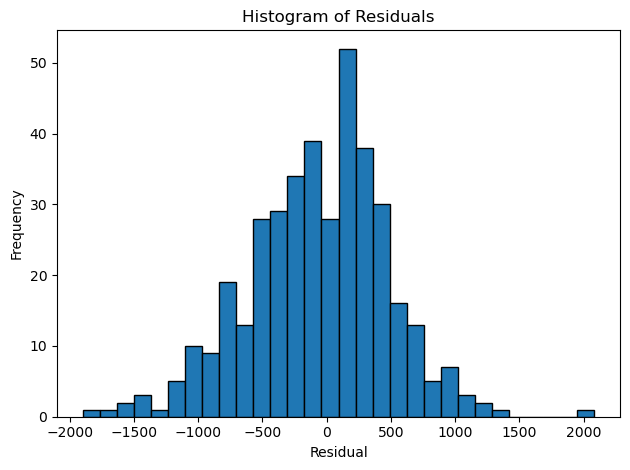

In [45]:
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.tight_layout()
plt.gcf().savefig(file_path_residuals_hist)
plt.show()


In [46]:
residuals.describe()

count     390.000000
mean      -66.816820
std       544.278555
min     -1898.938477
25%      -417.509155
50%       -33.605713
75%       278.300049
max      2084.246338
Name: bike_count, dtype: float64

In [47]:
top_5_residuals = residuals.nlargest(5)
print(top_5_residuals)

353    2084.246338
352    1390.905762
287    1182.331787
112    1157.514160
338    1141.790039
Name: bike_count, dtype: float64


In [48]:
bottom_5_residuals = residuals.nsmallest(5)
print(bottom_5_residuals)

232   -1898.938477
229   -1679.900879
236   -1509.933594
233   -1502.351562
234   -1466.307129
Name: bike_count, dtype: float64


In [49]:
residuals[5]

719.890869140625

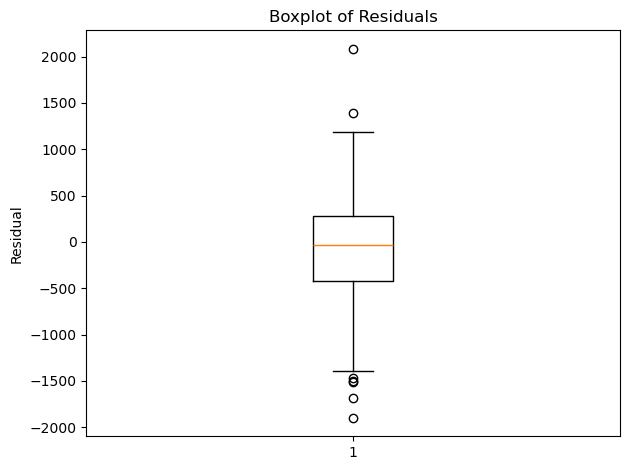

In [50]:
file_name_boxplot_residuals = "boxplot_residuals.png"
file_path_boxplot_residuals = base_path_plots / file_name_boxplot_residuals

boxplot_residuals = plt.boxplot(residuals)
plt.title("Boxplot of Residuals")
plt.ylabel("Residual")
plt.tight_layout()
plt.gcf().savefig(file_path_boxplot_residuals)
plt.show()



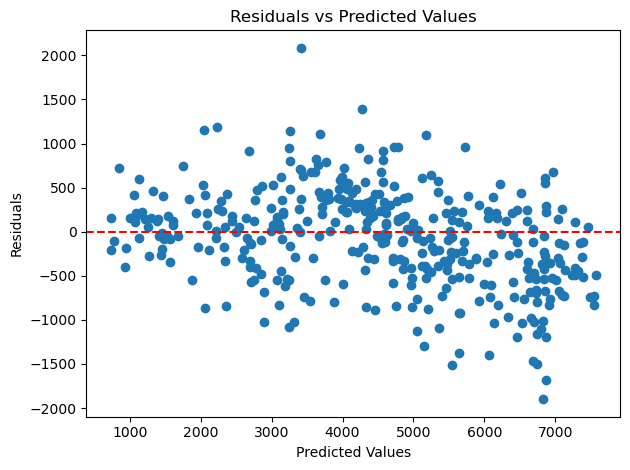

In [51]:
file_name_res_vs_pred_plot = "res_vs_pred_plot.png"
file_path_res_vs_pred_plot = base_path_plots / file_name_res_vs_pred_plot

res_vs_pred_plot = plt.scatter(predicted_mean, residuals)
plt.axhline(y=0, color='r', linestyle='--')  # Horizontale Linie bei 0
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.gcf().savefig(file_path_res_vs_pred_plot)
plt.show()


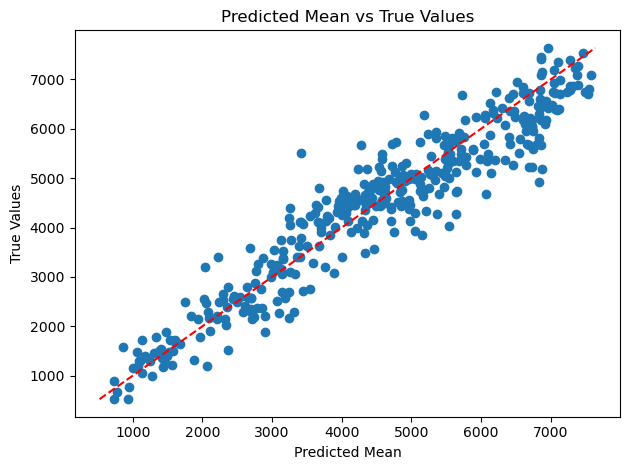

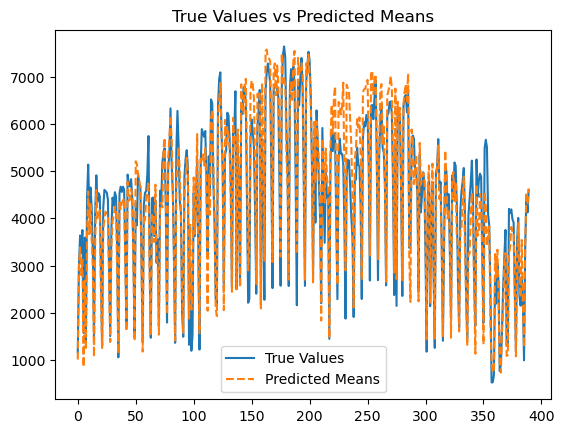

In [52]:
# Scatter plot
plt.scatter(predicted_mean, y_test)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.title("Predicted Mean vs True Values")
plt.xlabel("Predicted Mean")
plt.ylabel("True Values")

file_name_scatter_plot = "scatter_plot.png"
file_path_scatter_plot = base_path_plots / file_name_scatter_plot
plt.tight_layout()  
plt.gcf().savefig(file_path_scatter_plot)
plt.show()

# Line plot
plt.plot(y_test, label="True Values")
plt.plot(predicted_mean, label="Predicted Means", linestyle='--')
plt.legend()
plt.title("True Values vs Predicted Means")
plt.show()


In [53]:
standardized_residuals = residuals / predicted_std

standardized_residuals_df = pd.DataFrame(standardized_residuals)

In [54]:
standardized_residuals_df.describe()

,bike_count
count,390.000000
mean,0.006771
std,0.857984
min,-2.243151
25%,-0.503259
50%,-0.040508
75%,0.460520
max,4.800844


In [55]:
standardized_residuals_df
max_index = np.argmax(np.abs(standardized_residuals))
print(f"Index of max column: {max_index}")

Index of max column: 5


In [56]:
index_2largest_residual = 353

In [57]:
standardized_residuals.dtype

dtype('float64')

In [58]:
standardized_residuals.nlargest(5)

5      4.800844
353    3.733240
112    2.776448
343    2.693043
287    2.576919
Name: bike_count, dtype: float64

In [59]:
y_test.iloc[max_index]

1574.0

In [60]:
y_test.iloc[index_2largest_residual]

5504.0

In [61]:
predicted_mean[max_index]

854.10913

In [62]:
predicted_std[max_index]

149.95091

In [63]:
predicted_mean[index_2largest_residual]

3419.7537

In [64]:
predicted_std[index_2largest_residual]

558.29425

In [65]:
X_test.iloc[max_index]

temperature                -0.243547
precipitation              -0.397192
public_holiday_indicator    1.000000
is_workday                  0.000000
day_of_week                 4.000000
spring                      0.000000
summer                      0.000000
autumn                      0.000000
winter                      1.000000
windspeed                   0.943456
sun                        -0.932026
school_holiday_indicator    1.000000
Name: 5, dtype: float64

In [66]:
X_test.iloc[index_2largest_residual]

temperature                -0.827740
precipitation               1.250275
public_holiday_indicator    0.000000
is_workday                  1.000000
day_of_week                 2.000000
spring                      0.000000
summer                      0.000000
autumn                      0.000000
winter                      1.000000
windspeed                   1.910654
sun                        -0.852447
school_holiday_indicator    0.000000
Name: 353, dtype: float64

In [67]:
X_test.describe()

,temperature,precipitation,public_holiday_indicator,is_workday,day_of_week,spring,summer,autumn,winter,windspeed,sun,school_holiday_indicator
count,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
mean,0.045667,0.069920,0.035897,0.684615,2.992308,0.235897,0.235897,0.233333,0.294872,0.265790,-0.028741,0.225641
std,1.038212,0.933852,0.186273,0.465266,2.004479,0.425104,0.425104,0.423496,0.456571,1.149807,1.010414,0.418541
min,-2.436286,-0.397192,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.398428,-1.094803,0.000000
25%,-0.692915,-0.397192,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.593601,-0.967295,0.000000
50%,-0.027315,-0.397192,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.018412,-0.311666,0.000000
75%,0.969002,0.085464,0.000000,1.000000,5.000000,0.000000,0.000000,0.000000,1.000000,0.855050,0.770799,0.000000
max,2.199509,5.600619,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.000000,4.140128,2.146262,1.000000


In [68]:
y_test.describe()

count     390.000000
mean     4416.323828
std      1648.149287
min       524.000000
25%      3244.500000
50%      4598.500000
75%      5592.500000
max      7637.000000
Name: bike_count, dtype: float64

In [69]:
bottom_5_temps = X_test['precipitation'].nsmallest(5)
print(bottom_5_temps)

0   -0.397192
2   -0.397192
5   -0.397192
6   -0.397192
9   -0.397192
Name: precipitation, dtype: float64


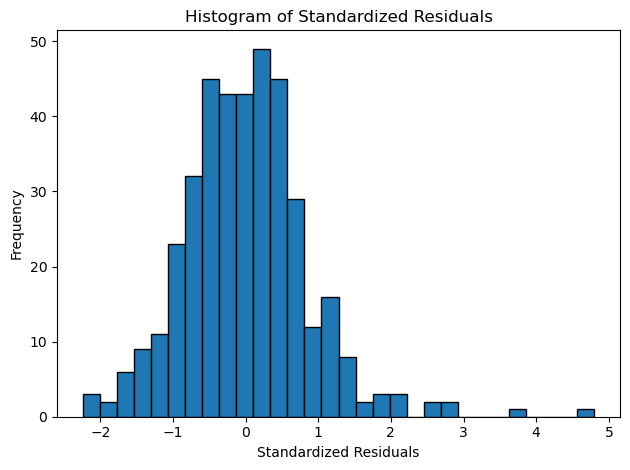

In [70]:
residuals_histogramm = plt.hist(standardized_residuals, bins=30, edgecolor='k')
plt.title("Histogram of Standardized Residuals")
plt.xlabel("Standardized Residuals")
plt.ylabel("Frequency")

plt.tight_layout()
plt.gcf().savefig(r"C:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Abbildungen\(08) Fahrraddaten_GridSearchTests2\standardized_residuals_histogramm.png")
plt.show()
plt.close()


In [71]:
# Calculate prediction intervals (95% confidence interval)
lower_bound = predicted_mean - norm.ppf(0.975) * predicted_std
upper_bound = predicted_mean + norm.ppf(0.975) * predicted_std

### Other

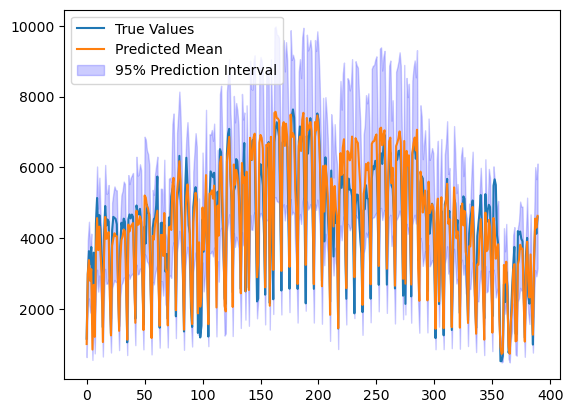

In [72]:
plt.plot(y_test, label="True Values")
plt.plot(predicted_mean, label="Predicted Mean")
plt.fill_between(range(len(y_test)), lower_bound, upper_bound, color='b', alpha=0.2, label="95% Prediction Interval")
plt.legend()
plt.show()


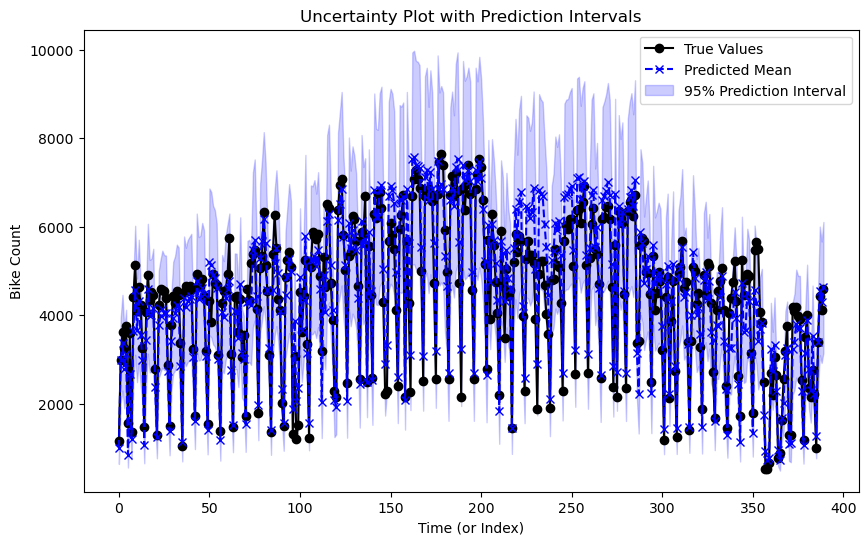

In [73]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, label="True Values", marker='o', linestyle='-', color='black')
plt.plot(predicted_mean, label="Predicted Mean", marker='x', linestyle='--', color='blue')
plt.fill_between(range(len(y_test)), lower_bound, upper_bound, color='blue', alpha=0.2, label="95% Prediction Interval")
plt.xlabel("Time (or Index)")
plt.ylabel("Bike Count")
plt.title("Uncertainty Plot with Prediction Intervals")
plt.legend()
plt.show()

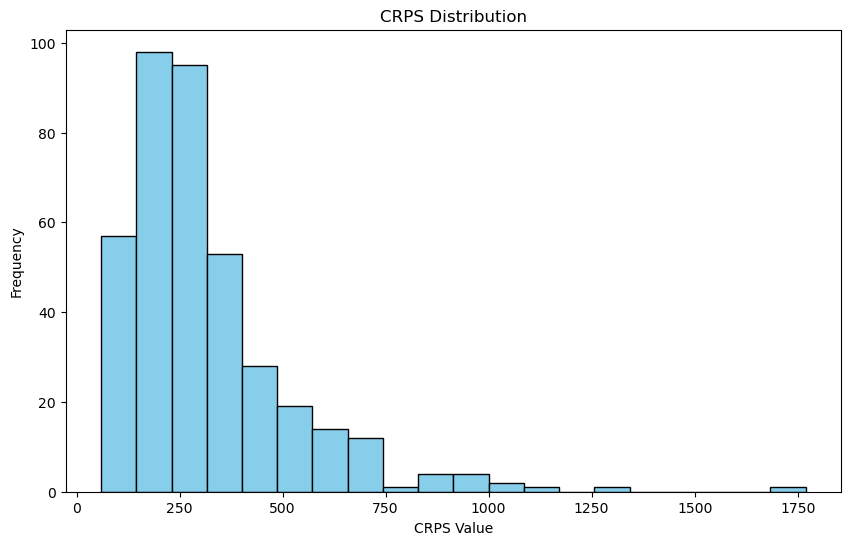

In [74]:
# Plot CRPS distribution
plt.figure(figsize=(10, 6))
plt.hist(crps_values, bins=20, color='skyblue', edgecolor='black')
plt.xlabel("CRPS Value")
plt.ylabel("Frequency")
plt.title("CRPS Distribution")
plt.show()

In [75]:
crps_values_df = pd.DataFrame(crps_values)

In [76]:
crps_values_df

,0
0,89.496629
1,114.162095
2,174.627410
3,283.346121
4,391.795181
...,...
385,169.234879
386,129.568634
387,181.857205
388,180.319765


In [77]:
crps_series = pd.Series(crps_values)

In [78]:
crps_series.nlargest(5)

353    1769.287731
232    1312.491287
229    1114.680853
236    1036.198214
352    1010.041689
dtype: float64

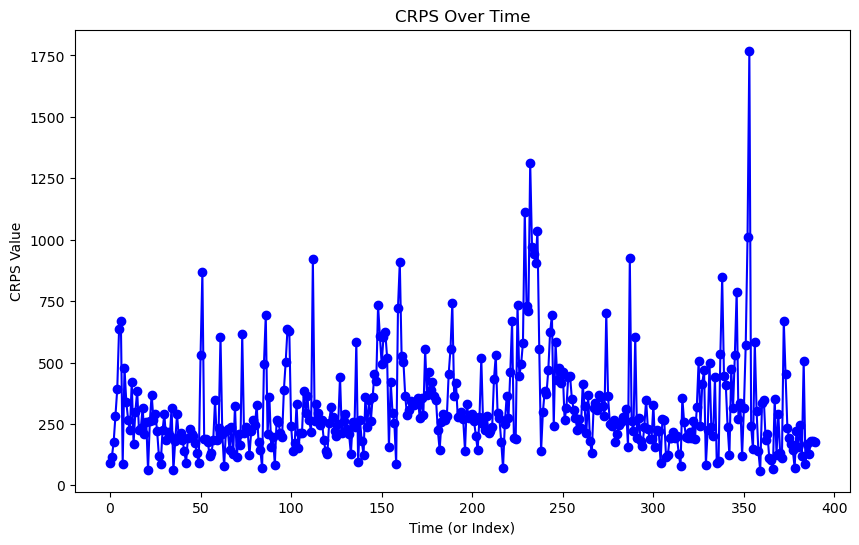

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(crps_values, marker='o', linestyle='-', color='blue')
plt.xlabel("Time (or Index)")
plt.ylabel("CRPS Value")
plt.title("CRPS Over Time")
plt.show()

In [80]:
from scipy.special import erfinv

In [81]:
base_path_plots

WindowsPath('C:/Users/aisti/OneDrive/Dokumente/Uni/Bachelorarbeit/Abbildungen/(08) Fahrraddaten_GridSearchTests2')

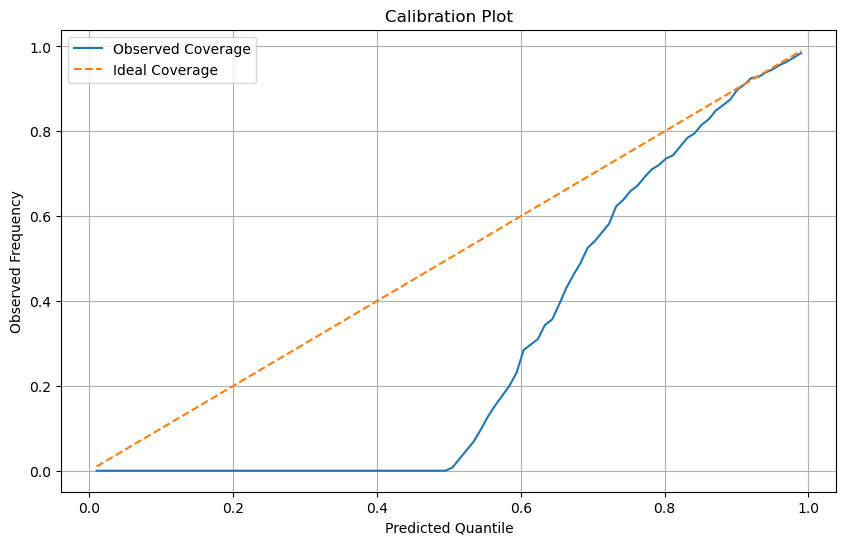

In [82]:
quantiles = np.linspace(0.01, 0.99, 100)
coverage = []

for q in quantiles:
    z = np.sqrt(2) * erfinv(2 * q - 1)
    lower_bound = predicted_mean - z * predicted_std
    upper_bound = predicted_mean + z * predicted_std
    within_interval = (y_test >= lower_bound) & (y_test <= upper_bound)
    coverage.append(np.mean(within_interval))

# Plot calibration curve
plt.figure(figsize=(10, 6))
plt.plot(quantiles, coverage, label="Observed Coverage")
plt.plot(quantiles, quantiles, '--', label="Ideal Coverage")
plt.xlabel("Predicted Quantile")
plt.ylabel("Observed Frequency")
plt.title("Calibration Plot")
plt.legend()
plt.grid()
plt.gcf().savefig(base_path_plots / "calibration_plot.png")
plt.show()

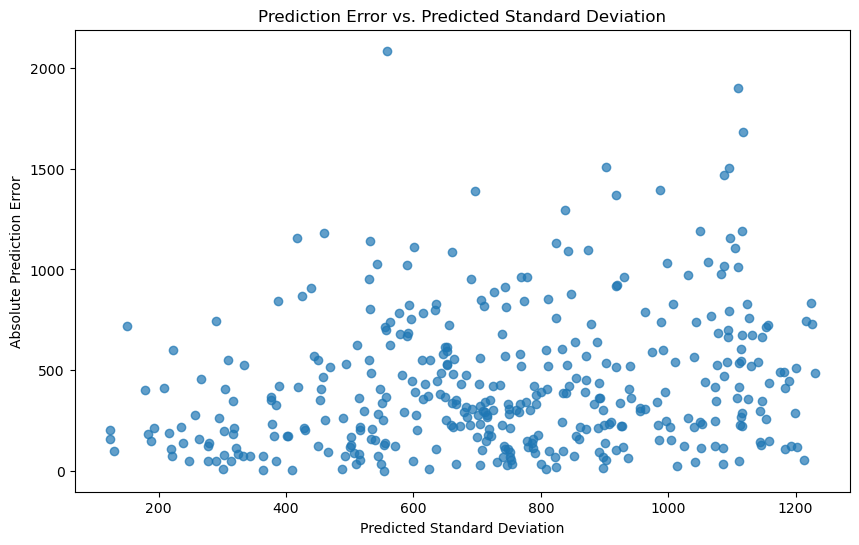

Correlation between predicted std and errors: 0.22


In [83]:
errors = np.abs(y_test - predicted_mean)

# Plot errors vs predicted standard deviations
plt.figure(figsize=(10, 6))
plt.scatter(predicted_std, errors, alpha=0.7)
plt.xlabel("Predicted Standard Deviation")
plt.ylabel("Absolute Prediction Error")
plt.title("Prediction Error vs. Predicted Standard Deviation")
plt.show()

# Calculate correlation coefficient
correlation = np.corrcoef(predicted_std, errors)[0, 1]
print(f"Correlation between predicted std and errors: {correlation:.2f}")

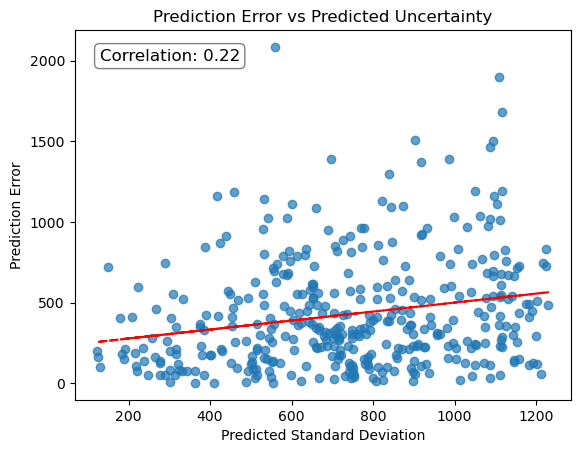

In [84]:
# Scatter plot
plt.scatter(predicted_std, errors, alpha=0.7)
plt.xlabel("Predicted Standard Deviation")
plt.ylabel("Prediction Error")
plt.title("Prediction Error vs Predicted Uncertainty")

# Calculate and plot trendline
z = np.polyfit(predicted_std, errors, 1)  # Linear fit
p = np.poly1d(z)
plt.plot(predicted_std, p(predicted_std), color="red", linestyle="--")

# Show correlation coefficient on the plot
plt.text(0.05, 0.95, f"Correlation: {correlation:.2f}", transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))
plt.gcf().savefig(base_path_plots / "prediction_error_vs_predicted_uncertainty.png")
# Show plot
plt.show()


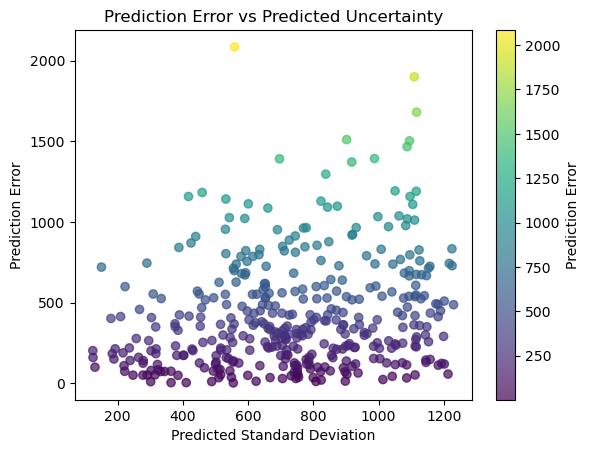

In [85]:
plt.scatter(predicted_std, errors, c=errors, cmap='viridis', alpha=0.7)
plt.xlabel("Predicted Standard Deviation")
plt.ylabel("Prediction Error")
plt.title("Prediction Error vs Predicted Uncertainty")
plt.colorbar(label="Prediction Error")
plt.gcf().savefig(base_path_plots / "prediction_error_vs_predicted_uncertainty_colored.png")
plt.show()

### Scores

In [86]:
coverage = np.mean((y_test >= lower_bound) & (y_test <= upper_bound))

print(f"PICP (Prediction Interval Coverage Probability): {coverage:.2f}")

#picp represents the percentage of actual values that fall within the prediction interval
#97 percent of true values fall within 95% of the prediction interval

PICP (Prediction Interval Coverage Probability): 0.98


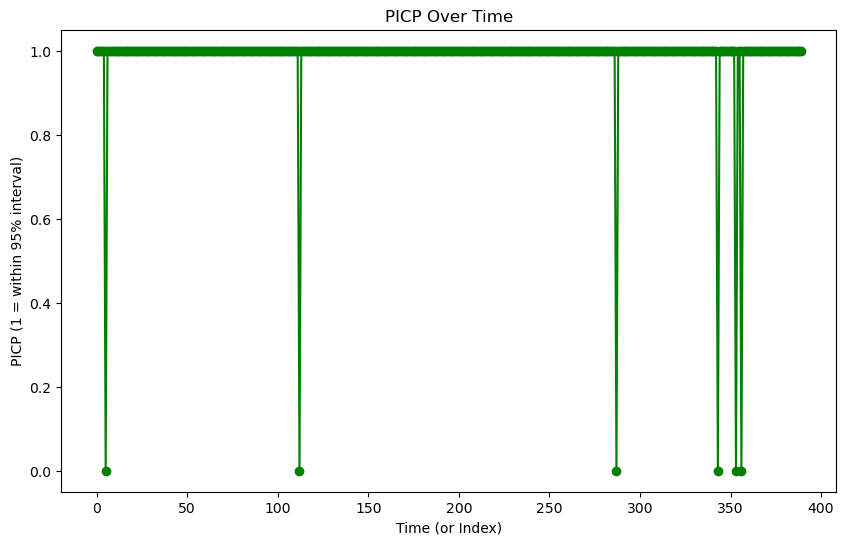

In [87]:
# Calculate PICP for each time point
picp_over_time = (y_test >= lower_bound) & (y_test <= upper_bound)

# Plot PICP over time
plt.figure(figsize=(10, 6))
plt.plot(picp_over_time, marker='o', linestyle='-', color='green')
plt.xlabel("Time (or Index)")
plt.ylabel("PICP (1 = within 95% interval)")
plt.title("PICP Over Time")
plt.show()

In [88]:
brier_scores = np.mean((norm.cdf(y_test, loc=predicted_mean, scale=predicted_std) - 1)**2)
print(f"Brier Score: {brier_scores:.4f}")

Brier Score: 0.3172


In [89]:
mae = np.mean(np.abs(y_test - predicted_mean))
rmse = np.sqrt(np.mean((y_test - predicted_mean)**2))
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}")

MAE: 427.95, RMSE: 547.67


### How do different parameter choices affect the predictions?

In [90]:
cv_results_df = pd.DataFrame(loaded_grid_search_tuned.cv_results_)

In [91]:
cv_results_df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_batch_size', 'param_model__dropout_rate',
       'param_model__n_blocks', 'param_model__n_neurons',
       'param_model__reg_value', 'param_optimizer__learning_rate', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [92]:
df_cv_scores = pd.DataFrame(loaded_grid_search_tuned.cv_results_)[['mean_test_score', 'std_test_score']]

In [93]:
df_cv_scores

,mean_test_score,std_test_score
0,-527.810923,29.280776
1,-527.506643,30.614163
2,-531.573903,30.211575
3,-532.588938,28.821427
4,-521.111674,31.957343
...,...,...
67,-468.536692,43.785203
68,-407.338857,19.619218
69,-401.298747,22.887313
70,-410.218109,40.411999


In [94]:
df_cv_scores_not_negated = df_cv_scores.copy()
df_cv_scores_not_negated['mean_test_score'] = df_cv_scores_not_negated['mean_test_score'] * -1


In [95]:
df_cv_scores_not_negated

,mean_test_score,std_test_score
0,527.810923,29.280776
1,527.506643,30.614163
2,531.573903,30.211575
3,532.588938,28.821427
4,521.111674,31.957343
...,...,...
67,468.536692,43.785203
68,407.338857,19.619218
69,401.298747,22.887313
70,410.218109,40.411999


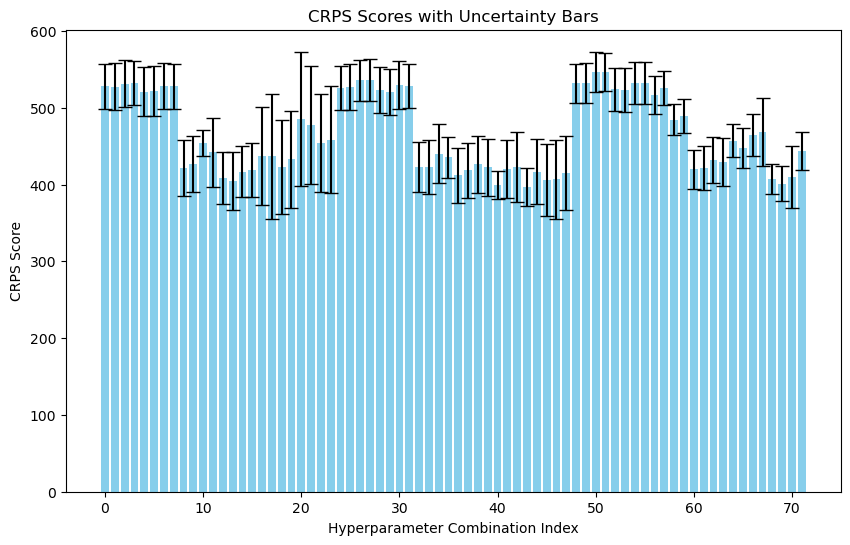

In [96]:
# Plotting with uncertainty bars
plt.figure(figsize=(10, 6))
plt.bar(df_cv_scores_not_negated.index, df_cv_scores_not_negated['mean_test_score'], 
        yerr=df_cv_scores_not_negated['std_test_score'], capsize=5, color='skyblue')
plt.xlabel('Hyperparameter Combination Index')
plt.ylabel('CRPS Score')
plt.title('CRPS Scores with Uncertainty Bars')
plt.show()


In [97]:
df_cv_scores

,mean_test_score,std_test_score
0,-527.810923,29.280776
1,-527.506643,30.614163
2,-531.573903,30.211575
3,-532.588938,28.821427
4,-521.111674,31.957343
...,...,...
67,-468.536692,43.785203
68,-407.338857,19.619218
69,-401.298747,22.887313
70,-410.218109,40.411999


In [98]:
loaded_grid_search_tuned.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=3,
             estimator=KerasRegressor(epochs=200, model=<function tune_nn.<locals>.create_model at 0x00000178AEB7F380>, verbose=0),
             n_jobs=1,
             param_grid={'batch_size': [32],
                         'model__dropout_rate': [0, 0.25, 0.5],
                         'model__n_blocks': [1, 2, 4],
                         'model__n_neurons': [128, 256],
                         'model__reg_value': [0, 0.01],
                         'optimizer__learning_rate': [0.001, 0.0001]},
             scoring=make_scorer(crps_loss_function_wrapper, greater_is_better=False, response_method='predict'),
             verbose=10)>

In [99]:
loaded_grid_search_tuned.best_params_

{'batch_size': 32,
 'model__dropout_rate': 0.25,
 'model__n_blocks': 4,
 'model__n_neurons': 128,
 'model__reg_value': 0.01,
 'optimizer__learning_rate': 0.0001}

In [100]:
cv_results_df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_batch_size,param_model__dropout_rate,param_model__n_blocks,param_model__n_neurons,param_model__reg_value,param_optimizer__learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,41.558577,0.780949,0.172020,0.005978,32,0.0,1,128,0.00,0.0010,"{'batch_size': 32, 'model__dropout_rate': 0, '...",-533.904175,-489.293182,-560.235413,-527.810923,29.280776,58
1,47.788275,5.322152,0.162534,0.006717,32,0.0,1,128,0.00,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0, '...",-531.344849,-488.240631,-562.934448,-527.506643,30.614163,57
2,41.556405,1.476591,0.161075,0.000932,32,0.0,1,128,0.01,0.0010,"{'batch_size': 32, 'model__dropout_rate': 0, '...",-535.970581,-492.570526,-566.180603,-531.573903,30.211575,63
3,41.849932,1.585291,0.168969,0.010021,32,0.0,1,128,0.01,0.0001,"{'batch_size': 32, 'model__dropout_rate': 0, '...",-536.268066,-495.594574,-565.904175,-532.588938,28.821427,68
4,42.038302,1.225160,0.167856,0.001438,32,0.0,1,256,0.00,0.0010,"{'batch_size': 32, 'model__dropout_rate': 0, '...",-530.576660,-478.107544,-554.650818,-521.111674,31.957343,49


In [101]:
cv_results_df['mean_test_score'] = cv_results_df['mean_test_score'] * -1

In [102]:
base_path_plots

WindowsPath('C:/Users/aisti/OneDrive/Dokumente/Uni/Bachelorarbeit/Abbildungen/(08) Fahrraddaten_GridSearchTests2')

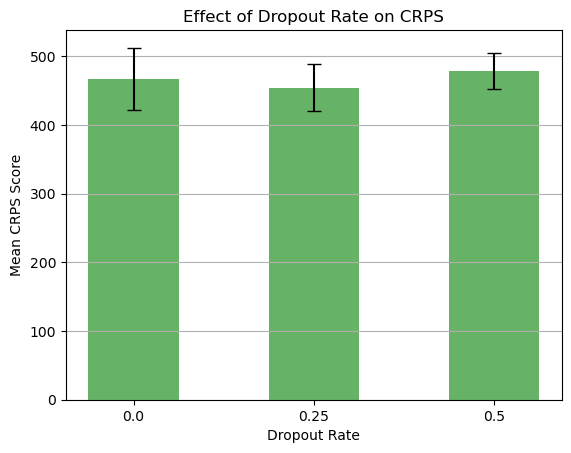

In [103]:
dropout_rates = cv_results_df['param_model__dropout_rate'].unique()
mean_crps_dropout = [cv_results_df[cv_results_df['param_model__dropout_rate'] == dr]['mean_test_score'].mean() for dr in dropout_rates]
std_crps_dropout = [cv_results_df[cv_results_df['param_model__dropout_rate'] == dr]['std_test_score'].mean() for dr in dropout_rates]

bar_width = 0.4 
index = np.arange(len(dropout_rates))  *0.8

plt.bar(index, mean_crps_dropout, yerr=std_crps_dropout, capsize=5, color='green', alpha=0.6, width=bar_width, label="Dropout Rate")

plt.title("Effect of Dropout Rate on CRPS")
plt.xlabel("Dropout Rate")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, dropout_rates)  
plt.grid(True, axis='y')
plt.gcf().savefig(base_path_plots / "dropout_rate_effect.png")
plt.show()

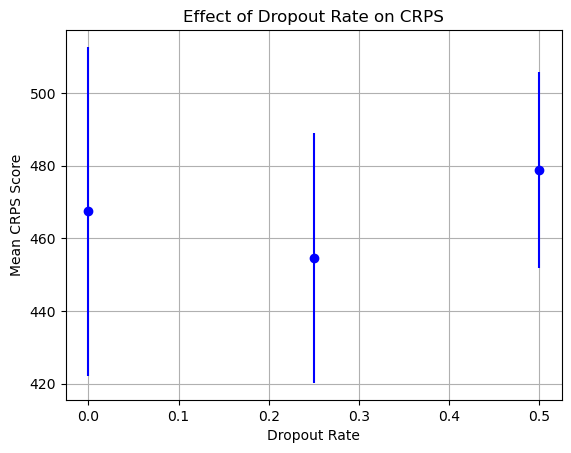

In [104]:
# For plotting the dropout_rate effect:
dropout_rates = cv_results_df['param_model__dropout_rate'].unique()
mean_crps_dropout = [cv_results_df[cv_results_df['param_model__dropout_rate'] == dr]['mean_test_score'].mean() for dr in dropout_rates]
std_crps_dropout = [cv_results_df[cv_results_df['param_model__dropout_rate'] == dr]['std_test_score'].mean() for dr in dropout_rates]

# Plotting for dropout_rate
plt.errorbar(dropout_rates, mean_crps_dropout, yerr=std_crps_dropout, fmt='o', label="Dropout Rate", color='blue')
plt.title("Effect of Dropout Rate on CRPS")
plt.xlabel("Dropout Rate")
plt.ylabel("Mean CRPS Score")
plt.grid(True)
plt.show()

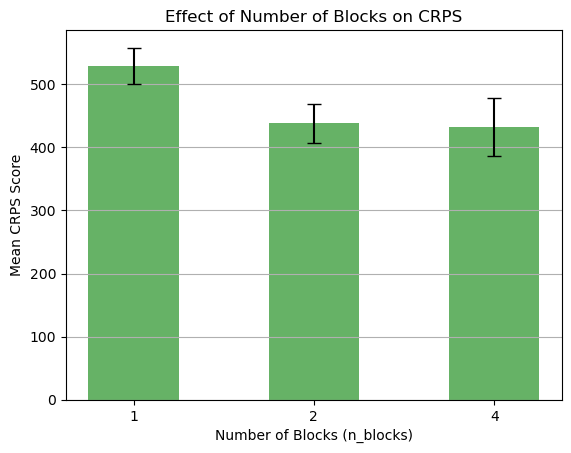

In [105]:
n_blocks_values = cv_results_df['param_model__n_blocks'].unique()
mean_crps_n_blocks = [cv_results_df[cv_results_df['param_model__n_blocks'] == nb]['mean_test_score'].mean() for nb in n_blocks_values]
std_crps_n_blocks = [cv_results_df[cv_results_df['param_model__n_blocks'] == nb]['std_test_score'].mean() for nb in n_blocks_values]

bar_width = 0.4  
index = np.arange(len(n_blocks_values))  *0.8

plt.bar(index, mean_crps_n_blocks, yerr=std_crps_n_blocks, capsize=5, color='green', alpha=0.6, width=bar_width, label="n_blocks")

plt.title("Effect of Number of Blocks on CRPS")
plt.xlabel("Number of Blocks (n_blocks)")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, n_blocks_values)  
plt.grid(True, axis='y')
plt.gcf().savefig(base_path_plots / "n_blocks_effect.png")
plt.show()


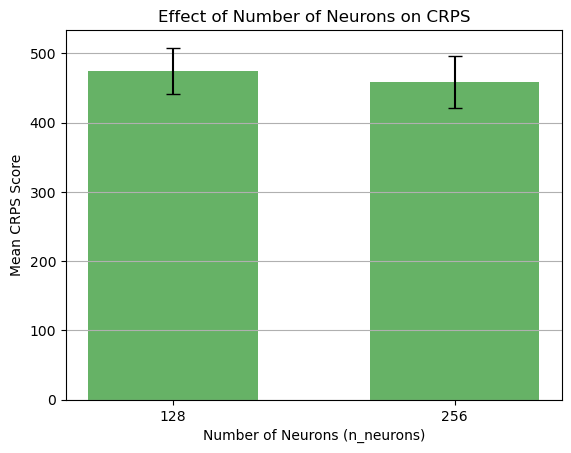

In [106]:
n_neurons_values = cv_results_df['param_model__n_neurons'].unique()
mean_crps_n_neurons = [cv_results_df[cv_results_df['param_model__n_neurons'] == nn]['mean_test_score'].mean() for nn in n_neurons_values]
std_crps_n_neurons = [cv_results_df[cv_results_df['param_model__n_neurons'] == nn]['std_test_score'].mean() for nn in n_neurons_values]


bar_width = 0.18 
index = np.arange(len(n_neurons_values)) *0.3

plt.bar(index, mean_crps_n_neurons, yerr=std_crps_n_neurons, capsize=5, color='green', alpha=0.6, width=bar_width, label="n_neurons")

plt.title("Effect of Number of Neurons on CRPS")
plt.xlabel("Number of Neurons (n_neurons)")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, n_neurons_values) 
plt.grid(True, axis='y')
plt.gcf().savefig(base_path_plots / "n_neurons_effect.png")
plt.show()


In [107]:
mean_crps_n_neurons

[474.7887607150608, 459.0535216154876]

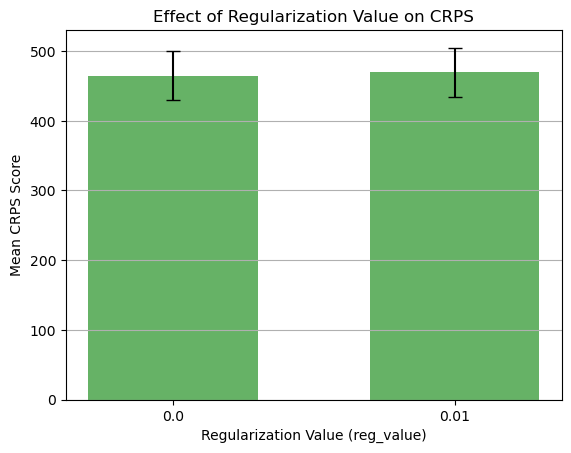

In [108]:
reg_value_values = cv_results_df['param_model__reg_value'].unique()
mean_crps_reg_value = [cv_results_df[cv_results_df['param_model__reg_value'] == rv]['mean_test_score'].mean() for rv in reg_value_values]
std_crps_reg_value = [cv_results_df[cv_results_df['param_model__reg_value'] == rv]['std_test_score'].mean() for rv in reg_value_values]

bar_width = 0.18
index = np.arange(len(reg_value_values))*0.3

plt.bar(index, mean_crps_reg_value, yerr=std_crps_reg_value, capsize=5, color='green', alpha=0.6, width=bar_width, label="reg_value")

plt.title("Effect of Regularization Value on CRPS")
plt.xlabel("Regularization Value (reg_value)")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, reg_value_values)
plt.grid(True, axis='y')
plt.gcf().savefig(base_path_plots / "reg_value_effect.png")
plt.show()


In [109]:
mean_crps_reg_value

[464.49054915816697, 469.3517331723813]

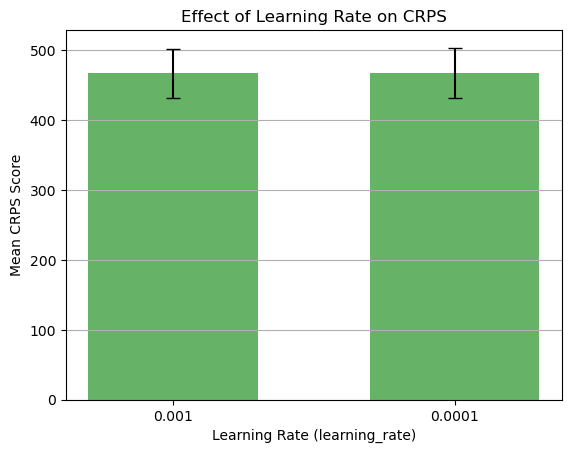

In [110]:
learning_rate_values = cv_results_df['param_optimizer__learning_rate'].unique()
mean_crps_learning_rate = [cv_results_df[cv_results_df['param_optimizer__learning_rate'] == lr]['mean_test_score'].mean() for lr in learning_rate_values]
std_crps_learning_rate = [cv_results_df[cv_results_df['param_optimizer__learning_rate'] == lr]['std_test_score'].mean() for lr in learning_rate_values]

bar_width = 0.18
index = np.arange(len(learning_rate_values)) * 0.3


plt.bar(index, mean_crps_learning_rate, yerr=std_crps_learning_rate, capsize=5, color='green', alpha=0.6, width=bar_width, label="learning_rate")
plt.title("Effect of Learning Rate on CRPS")
plt.xlabel("Learning Rate (learning_rate)")
plt.ylabel("Mean CRPS Score")
plt.xticks(index, learning_rate_values)
plt.grid(True, axis='y')
plt.gcf().savefig(base_path_plots / "learning_rate_effect.png")
plt.show()


In [111]:
mean_crps_learning_rate

[466.62081061469183, 467.22147171585647]

In [112]:
loaded_grid_search_tuned.best_params_

{'batch_size': 32,
 'model__dropout_rate': 0.25,
 'model__n_blocks': 4,
 'model__n_neurons': 128,
 'model__reg_value': 0.01,
 'optimizer__learning_rate': 0.0001}

In [113]:
loaded_grid_search_tuned.get_params

<bound method BaseEstimator.get_params of GridSearchCV(cv=3,
             estimator=KerasRegressor(epochs=200, model=<function tune_nn.<locals>.create_model at 0x00000178AEB7F380>, verbose=0),
             n_jobs=1,
             param_grid={'batch_size': [32],
                         'model__dropout_rate': [0, 0.25, 0.5],
                         'model__n_blocks': [1, 2, 4],
                         'model__n_neurons': [128, 256],
                         'model__reg_value': [0, 0.01],
                         'optimizer__learning_rate': [0.001, 0.0001]},
             scoring=make_scorer(crps_loss_function_wrapper, greater_is_better=False, response_method='predict'),
             verbose=10)>

In [114]:
mean_crps = predict_and_calculate_mean_crps(loaded_grid_search_tuned.best_estimator_.model_, X_test, y_test, print_predicted_mean_std = False)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Mean CRPS: 315.84538516468314
